<a href="https://colab.research.google.com/github/guerrac2001/Colab-Notebooks/blob/main/CNN_freelancer_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional neural networks for time series forecasting

### How to do it...

1. Import the libraries:

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 6.2 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Se almacenaron las variables requeridas y las librerias para llevar a cabo el modelo

In [2]:
import yfinance as yf
import numpy as np
import os
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict

from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.12.0+cu113


2. Define the parameters:

In [3]:
# data
import datetime

TICKER = "GOOG"
START_DATE = datetime.datetime (2018, 1, 1)
END_DATE = datetime.datetime.now()
VALID_START = datetime.datetime (2019,12,31)
N_LAGS = 24

# neural network 
BATCH_SIZE = 5

3. Download and prepare the data:

Se define la extraccion de los datos para entrenar el modelo en X y Y

In [4]:
import yfinance as yahooFinance

df = yahooFinance.download(TICKER,start=START_DATE, end=END_DATE,interval = "1mo", auto_adjust = True)

valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Close'].values
print(valid_size)

[*********************100%***********************]  1 of 1 completed
32


4. Transform the time series into input for the CNN:

In [5]:
def create_input_data(series, nAtras=1):
    x = []
    y = []
    for precio in range(len(series) - nAtras):
        finPrecio = precio + nAtras
        x.append(series[precio:finPrecio])
        y.append(series[finPrecio])
    return np.array(x), np.array(y)

Se tiene que desarrollar los datos quitando los valores no numericos generados en el numpy, en caso que al investigar o la persona que este manejando este reporte considere necesario normalizar para quitar el error puede quitar las dos lineas comentaadas y el codigo se manejara con normalidad

In [6]:
from scipy import stats
X, y = create_input_data(prices, N_LAGS)
X=np.nan_to_num(X)
y=np.nan_to_num(y)
#X=stats.zscore(X, axis = 1)
#y=stats.zscore(y)

5. Obtain the naïve forecast:

In [7]:
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]
y_valid=np.nan_to_num(y_valid)
naive_pred=np.nan_to_num(naive_pred)
naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 481.95, RMSE: 21.95


Se considera una alta debido al numero de datos y la variacion de esta a lo largo del tiempo 

In [8]:
def generaAleatoreaSemi(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

6. Prepare the `DataLoader` objects:

In [9]:
generaAleatoreaSemi(42)

#valid_ind = len(X) - valid_size
valid_ind=26
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)

Check the size of the datasets:

In [10]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 26 | validation: 6


7. Define the CNN's architecture:

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(384, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

print(model)

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=384, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)


8. Instantiate the model, the loss function and the optimizer:

In [12]:
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

9. Train the network:

In [13]:
PRINT_EVERY = 50
N_EPOCHS = 2000

train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './cnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 79.985319 	 Valid. loss: 39.671127
<50> - Train. loss: 27.586006 	 Valid. loss: 31.458680
<100> - Train. loss: 26.971315 	 Valid. loss: 54.028533
<150> - Train. loss: 35.995488 	 Valid. loss: 27.894776
<200> - Train. loss: 22.305133 	 Valid. loss: 34.094565
<250> - Train. loss: 22.052221 	 Valid. loss: 28.262883
<300> - Train. loss: 23.163278 	 Valid. loss: 41.092534
<350> - Train. loss: 24.305345 	 Valid. loss: 39.403953
<400> - Train. loss: 28.610216 	 Valid. loss: 40.263292
<450> - Train. loss: 19.111299 	 Valid. loss: 39.113187
<500> - Train. loss: 29.174816 	 Valid. loss: 51.197198
<550> - Train. loss: 24.363712 	 Valid. loss: 32.773256
<600> - Train. loss: 27.789935 	 Valid. loss: 36.756815
<650> - Train. loss: 16.190232 	 Valid. loss: 26.305449
<700> - Train. loss: 24.946242 	 Valid. loss: 31.255724
<750> - Train. loss: 21.779010 	 Valid. loss: 29.632657
<800> - Train. loss: 24.217838 	 Valid. loss: 31.488806
<850> - Train. loss: 21.456615 	 Valid. loss: 33.38

10. Plot the losses over epochs:

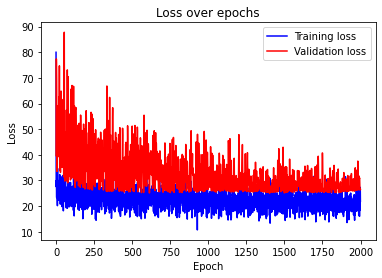

In [14]:
import matplotlib.pyplot as plt

train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()
plt.show()

12. Obtain the predictions:

In [15]:
y_pred, y_valid = [], []

with torch.no_grad():
    
    model.eval()
        
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

13. Evaluate the predictions:

CNN's forecast - MSE: 2114.74, RMSE: 45.99


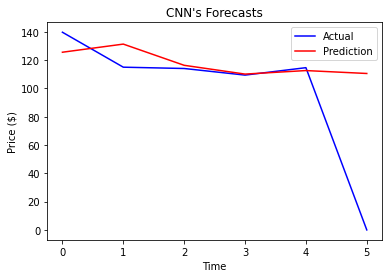

In [16]:
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"CNN's forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='Prediction')
#ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="CNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im12.png')
plt.show()